# Adjusting Pore Size Distributions

In this example we show how you can create your very own custom pore size distribution. We start by describing how the built-in models work to calculate pore and throat sizes. Next we show how to add a custom pore size distribution using a weibull distribution. Included in this example is how we might visualize our pore and throat size distributions in a histogram.

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spst
op.visualization.set_mpl_style()

## Network

Start by creating a standard cubic lattice topology.  Note that no pore or throat sizes are given yet, only the spacing between the lattice cells.  This spacing dictates the upper limit of pore sizes, since we don't generally want pores that exceed their cells and overlap their neighbors.  This causes geometrical paradoxes like negative throat lengths.  Here we'll use a large spacing so that the pore sizes do not need to be expressed in scientific notation below.

In [2]:
pn = op.network.Cubic(shape=[25, 25, 1], spacing=1)

We can visualize the cubic lattice we created using `plot_connections` found under `op.visualization`

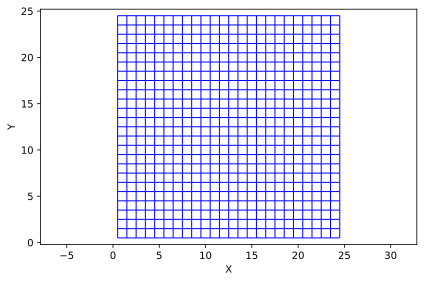

In [3]:
fig = op.visualization.plot_connections(network=pn)

## Geometry

Next we need to add pore and throat sizes to our network. OpenPNM has built in collections of geometry models ready to be added to a network object. For this example we will use the `spheres_and_cylinders` collection of geometry models. It is a dictionary of models containing everything you need to get started.  

> Pro tip, geometry models are stored in `op.models.geometry` and can be added to a network object directly from there using the `add_model` method on the network object.

In [4]:
geo = op.models.collections.geometry.spheres_and_cylinders

Remember that a model collection is just a dictionary of geometry models. This means that `geo` can be treated like any other python dictionary. This includes how we can get a list of keys using the `keys()` method. This is useful for quickly viewing the geometry models already in the model collection.

In [5]:
geo.keys()

dict_keys(['pore.seed', 'pore.max_size', 'pore.diameter', 'pore.volume', 'throat.max_size', 'throat.diameter', 'throat.length', 'throat.cross_sectional_area', 'throat.total_volume', 'throat.lens_volume', 'throat.volume', 'throat.diffusive_size_factors', 'throat.hydraulic_size_factors'])

Each dictionary key returns a model and any arguments.

In [6]:
geo['pore.diameter']

{'model': <function openpnm.models.misc._basic_math.product(target, props)>,
 'props': ['pore.max_size', 'pore.seed']}

Finally, we add the geometry models in `geo` to the network using `add_model_collections`. Don't forget to `regenerate_models` or else the models will not appear on the network object. Below we print the network object to show that the geometry models such as `pore.diameter` and `throat.diameter` have been added to the network object.

In [7]:
pn.add_model_collection(geo)
pn.regenerate_models()
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x1f9bd17b810>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coordination_number                                        625 / 625
  2  pore.coords                                                     625 / 625
  3  pore.diameter                                                   625 / 625
  4  pore.max_size                                                   625 / 625
  5  pore.seed                                                       625 / 625
  6  pore.volume                                                     625 / 625
  7  throat.conns                                                  1200 / 1200
  8  throat.cross_sectional_area                                   1200 / 1200
  9 

We can visualize the pore and throat size distribution from the built-in geometry models using `matplotlib` and their `hist` method. 

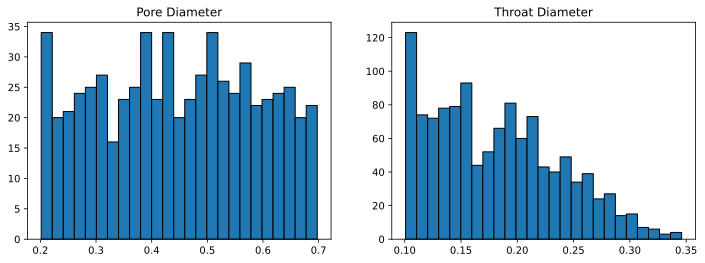

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,4])
ax1.hist(pn['pore.diameter'], bins=25, edgecolor='k')
ax1.set_title('Pore Diameter')
ax2.hist(pn['throat.diameter'], bins=25, edgecolor='k')
ax2.set_title('Throat Diameter');

## Adjusting Pore and Throat Sizes

We will show two approaches for adjusting pore sizes. The first is the most simple and straight forward approach using the `scipy.stats` module directly. The second uses pre-defined pore scale models in OpenPNM. The latter approach is recommended.

### Using scipy.stats classes directly

Let's start by fetching a statistical *class* from the ``scipy.stats`` module, in this case the ``weibull_min``:

In [9]:
f = spst.weibull_min

We can generate a list of pores sizes by generating a list of numbers using the `rvs` method below. Note that for the ``size`` of the array we put the number of pores on the network, so that we can assign one value to each pore as follows:

In [10]:
x = f.rvs(c=2, loc=0, scale=.4, size=pn.Np, random_state=None)

We can add this array of pore sizes directly to our network object like we would any python dictionary. Warning this overwrites the existing pore diameter. To update the throat diameter we need to `regenerate_models()`.

In [11]:
pn['pore.diameter'] = x
pn.regenerate_models()

Now visualize the new pore and throat size distribution

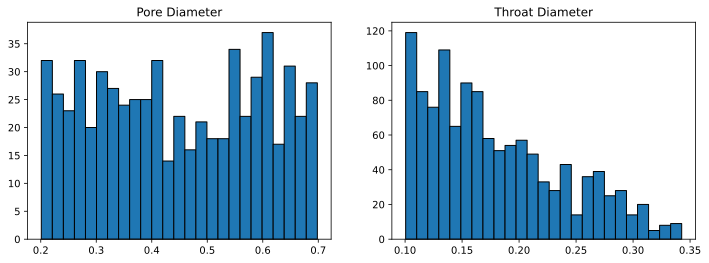

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,4])
ax1.hist(pn['pore.diameter'], bins=25, edgecolor='k')
ax1.set_title('Pore Diameter')
ax2.hist(pn['throat.diameter'], bins=25, edgecolor='k')
ax2.set_title('Throat Diameter');

### Using pre-defined models in OpenPNM

The advantage of using the built-in models from OpenPNM is that:

      a) you can regenerate the distribution programmatically using `regenerate_models()`
      b) you can save the project to file and the model information will be retained
      c) you can change parameters on the model to parametric studies very easily

Let's start by overwriting the hard coded pore diameters previously added with a model for pore diameters based on a weibull size distribution.

In [13]:
f = op.models.geometry.pore_size.weibull
pn.add_model(propname='pore.diameter', model=f, shape=2, scale=0.4, loc=0)

OpenPNM use a *reverse look-up* to get pores sizes. This means that a random number between 0 and 1 is assigned to each pore, then the corresponding size is determined based on the cumulative probability curve. This allows users to generate their own random numbers, for instance using spatial correlations, then assign sizes. 


The original geometry model collection added already included a model for `pore.seed` but we can adjust that models properties by doing the following. Just make sure to regenerate models on the network object afterwards.

In [14]:
f = op.models.geometry.pore_seed.random
pn.models['pore.seed']['num_range'] = [0.0, 0.99]
pn.regenerate_models()

Now that we've settled on pores sizes, we can assign throat sizes.  The throats should always be less than or equal to the size of the two pores they connect...otherwise they're not really throats.  

> OpenPNM will not break if this happens, but you'd need to check the consistency of the results very carefully.

To ensure the throats are always smaller than their connected pores, OpenPNM provides pore-scale model called ``from_neighbor_pores``.  This can be used to either (a) fetch the minimum pore size (and maybe also scale that value down), or (b) fetch the seed values from the pores and use that in a distinct distribution. We will demonstrate the second approach.

In [15]:
f = op.models.misc.from_neighbor_pores
pn.add_model(propname='throat.seed',
             model=f, prop='pore.seed', mode='min')
f = op.models.geometry.throat_size.weibull
pn.add_model(propname='throat.diameter_2',
             model=f, shape=1.5, scale=.2, loc=0)

Here, the Weibull parameters were carefully chosen to ensure a smaller distribution than the pore sizes, for reasons of geometrical consistency mentioned above. We can now visualize the resulting distribution.

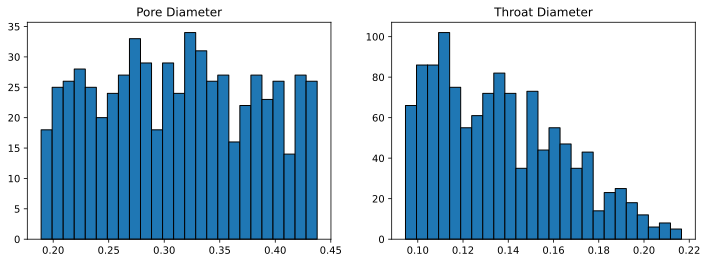

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 4])
ax1.hist(pn['pore.diameter'], bins=25, edgecolor='k')
ax1.set_title('Pore Diameter')
ax2.hist(pn['throat.diameter'], bins=25, edgecolor='k')
ax2.set_title('Throat Diameter');

If for some reason we were unhappy with the distribution, it can easily be changed and updated.  For instance, to reduce the number of small pores, we can adjust the ``num_range`` parameter on the ``'pore.seed'`` model and re-run:

In [17]:
pn.models['pore.seed']['num_range'] = [0.25, 0.99]
pn.regenerate_models()

Visualize the new distribution after changing `pore.seed`

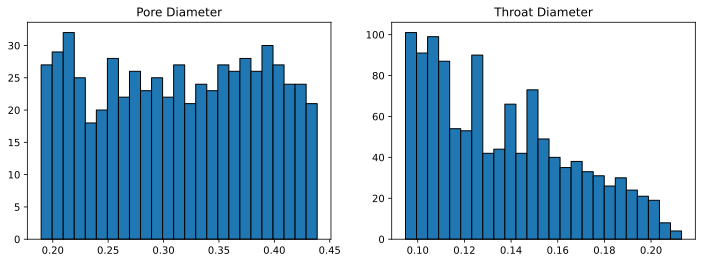

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 4])
ax1.hist(pn['pore.diameter'], bins=25, edgecolor='k')
ax1.set_title('Pore Diameter')
ax2.hist(pn['throat.diameter'], bins=25, edgecolor='k')
ax2.set_title('Throat Diameter');

This illustrates the power/utility of using pore-scale models properly, instead of essentially hard-coding the pore size values as was done by using the ``scipy.stats`` classes directly.

Plotting the network itself should ideally be done in Paraview, but a quick plot with `plot_networkx` shows the pore sizes.

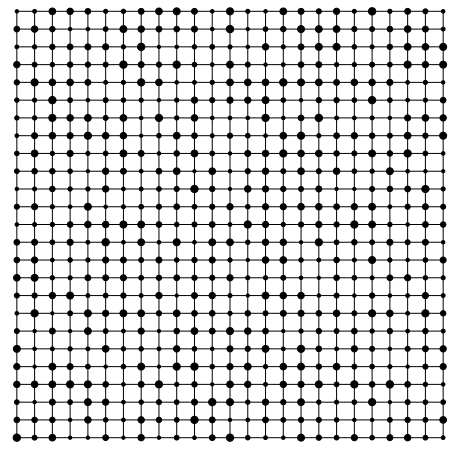

In [19]:
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
ig = op.visualization.plot_networkx(pn, scale=1, ax=ax)